In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F  # Import the functional module
import random


# Define the paths to the folders
base_path = 'cats_and_dogs'
test_cats_path = os.path.join(base_path, 'testcats')
test_dogs_path = os.path.join(base_path, 'testdogs')
train_cats_path = os.path.join(base_path, 'traincats')
train_dogs_path = os.path.join(base_path, 'traindogs')

# List the files in each directory
test_cats_files = os.listdir(test_cats_path)
test_dogs_files = os.listdir(test_dogs_path)
train_cats_files = os.listdir(train_cats_path)
train_dogs_files = os.listdir(train_dogs_path)

# Display the number of files in each folder
print(f"Test Cats: {len(test_cats_files)} images")
print(f"Test Dogs: {len(test_dogs_files)} images")
print(f"Train Cats: {len(train_cats_files)} images")
print(f"Train Dogs: {len(train_dogs_files)} images")


Test Cats: 70 images
Test Dogs: 70 images
Train Cats: 279 images
Train Dogs: 278 images


Sample Test Cat Image:


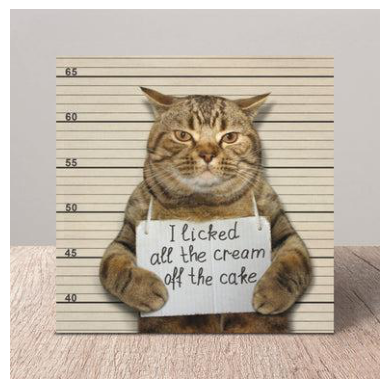

Sample Test Dog Image:


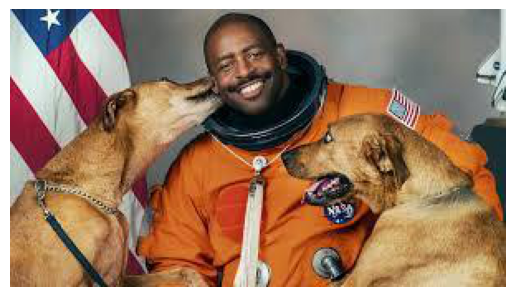

Sample Train Cat Image:


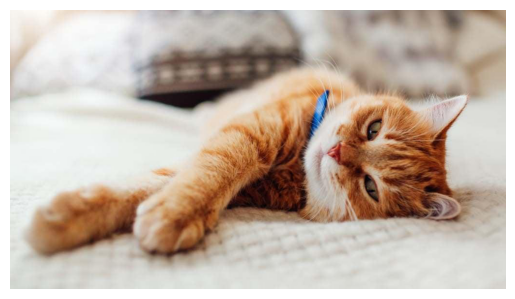

Sample Train Dog Image:


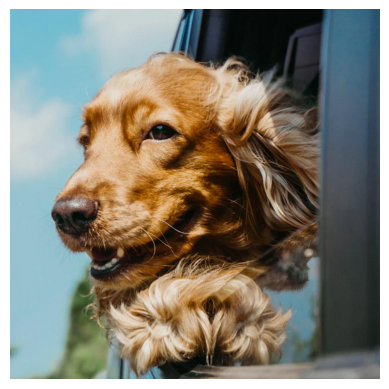

In [84]:
# Function to load and display an image
def load_and_display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Display a sample image from each folder
print("Sample Test Cat Image:")
load_and_display_image(os.path.join(test_cats_path, test_cats_files[0]))

print("Sample Test Dog Image:")
load_and_display_image(os.path.join(test_dogs_path, test_dogs_files[0]))

print("Sample Train Cat Image:")
load_and_display_image(os.path.join(train_cats_path, train_cats_files[0]))

print("Sample Train Dog Image:")
load_and_display_image(os.path.join(train_dogs_path, train_dogs_files[0]))


In [102]:
# Dataset class and DataLoader setup
class CatsAndDogsDataset(Dataset):
    def __init__(self, cats_dir, dogs_dir, transform=None):
        self.cats_dir = cats_dir
        self.dogs_dir = dogs_dir
        self.transform = transform
        self.cats_files = os.listdir(cats_dir)
        self.dogs_files = os.listdir(dogs_dir)
        self.all_files = [(os.path.join(cats_dir, f), 0) for f in self.cats_files] + \
                         [(os.path.join(dogs_dir, f), 1) for f in self.dogs_files]

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        img_path, label = self.all_files[idx]
        image = Image.open(img_path)
        # Convert to RGB if the image is not already in RGB mode
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations to apply to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset instances for training and testing
train_dataset = CatsAndDogsDataset(train_cats_path, train_dogs_path, transform=transform)
test_dataset = CatsAndDogsDataset(test_cats_path, test_dogs_path, transform=transform)

# Custom collate function to handle variable image sizes
def custom_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    labels = torch.tensor(labels)
    return images, labels

# Create data loaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)



In [88]:
# Dataset class and DataLoader setup as described earlier
class CatsAndDogsDataset(Dataset):
    def __init__(self, cats_dir, dogs_dir, transform=None):
        self.cats_dir = cats_dir
        self.dogs_dir = dogs_dir
        self.transform = transform
        self.cats_files = os.listdir(cats_dir)
        self.dogs_files = os.listdir(dogs_dir)
        self.all_files = [(os.path.join(cats_dir, f), 0) for f in self.cats_files] + \
                         [(os.path.join(dogs_dir, f), 1) for f in self.dogs_files]

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        img_path, label = self.all_files[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CatsAndDogsDataset('cats_and_dogs/traincats', 'cats_and_dogs/traindogs', transform=transform)
test_dataset = CatsAndDogsDataset('cats_and_dogs/testcats', 'cats_and_dogs/testdogs', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [104]:
# Define the Neural Network
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()


In [106]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [108]:
# Train the Model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model parameters
        running_loss += loss.item()
    
    # Print the average loss for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')



FileNotFoundError: [Errno 2] No such file or directory: 'cats_and_dogs/traincats/cat_24.jpg'

In [ ]:
# Evaluate the Model
model.eval()
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy of the model on the test dataset
print(f'Accuracy: {100 * correct / total:.2f}%')



In [ ]:
# Save the model's state dictionary (parameters)
torch.save(model.state_dict(), 'cats_and_dogs_model.pth')


In [ ]:
# Function to predict whether an image is a cat or a dog using the model
def predict_image(image_path, model, transform):
    # Load and preprocess the image
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Run the image through the model
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)

    # Interpret the output
    classes = ['Cat', 'Dog']
    return classes[predicted.item()]


In [ ]:
# Example usage with randomness
image_path = 'path_to_your_image.jpg'  # Replace with the path to your image
random_prediction = random_predict()
print(f'The image is a: {random_prediction}')

# If you also want to get the model's prediction (for comparison)
model_prediction = predict_image(image_path, model, transform)
print(f'According to the model, the image is a: {model_prediction}')